In [1]:
!nvidia-smi

Tue Feb 15 12:31:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    35W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [4]:
!mkdir data

In [5]:
!unzip -qq data.zip -d data

In [6]:
cd /content/drive/MyDrive/data

/content/drive/MyDrive/data


In [7]:
!rm -rf pokemon_jpg

In [8]:
from tensorflow import keras

In [9]:
dataset = keras.utils.image_dataset_from_directory(
    'pokemon',
    label_mode=None,
    image_size=(64,64),
    batch_size=32,
    smart_resize=True)

Found 819 files belonging to 1 classes.


In [10]:
dataset = dataset.map(lambda x: x / 255.)

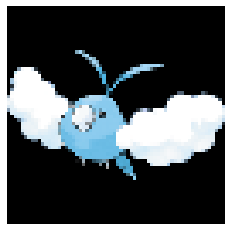

In [11]:
import matplotlib.pyplot as plt
for x in dataset:
    plt.axis('off')
    plt.imshow((x.numpy() * 255).astype('int32')[0])
    break

In [12]:
from tensorflow.keras import layers

discriminator = keras.Sequential([
    keras.Input(shape=(64,64,3)),
    layers.Conv2D(64, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(128, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(128, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')],
    
    name='discriminator')

In [13]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

In [14]:
latent_dim = 128

generator = keras.Sequential([
    keras.Input(shape=(latent_dim,)),
    layers.Dense(8*8*128),
    layers.Reshape((8,8,128)),
    layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(3, kernel_size=5, padding='same', activation='sigmoid')],
    
    name='generator')

In [15]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)       0 

In [16]:
import tensorflow as tf

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name='d_loss')
        self.g_loss_metric = keras.metrics.Mean(name='g_loss')
        
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        
    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]
    
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape = (batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat([tf.ones((batch_size,1)), tf.zeros((batch_size,1))], axis=0)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))
        
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.zeros((batch_size, 1))
        
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {'d_loss': self.d_loss_metric.result(),
                'g_loss': self.g_loss_metric.result()}

In [20]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        
    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(f'generated_img_2_{epoch:03d}_{i}.png')

In [18]:
epochs = 100

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

gan.compile(d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            loss_fn=keras.losses.BinaryCrossentropy())

In [19]:
gan.fit(dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)])

Epoch 1/100
26/26 [==============================] - 35s 800ms/step - d_loss: 0.5615 - g_loss: 1.0809
Epoch 2/100
26/26 [==============================] - 19s 685ms/step - d_loss: 0.3255 - g_loss: 1.0812
Epoch 3/100
26/26 [==============================] - 19s 682ms/step - d_loss: 0.3016 - g_loss: 1.0739
Epoch 4/100
26/26 [==============================] - 19s 684ms/step - d_loss: 0.1242 - g_loss: 2.4640
Epoch 5/100
26/26 [==============================] - 19s 682ms/step - d_loss: 0.0573 - g_loss: 4.4029
Epoch 6/100
26/26 [==============================] - 19s 680ms/step - d_loss: 0.0345 - g_loss: 5.7146
Epoch 7/100
26/26 [==============================] - 18s 680ms/step - d_loss: 0.0182 - g_loss: 7.0561
Epoch 8/100
26/26 [==============================] - 19s 680ms/step - d_loss: 0.0078 - g_loss: 8.7574
Epoch 9/100
26/26 [==============================] - 18s 679ms/step - d_loss: -0.0064 - g_loss: 10.8913
Epoch 10/100
26/26 [==============================] - 18s 680ms/step - d_loss: -

In [21]:
gan.fit(dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)])

Epoch 1/100
26/26 [==============================] - 19s 700ms/step - d_loss: 1.1949 - g_loss: 1.0780
Epoch 2/100
26/26 [==============================] - 20s 695ms/step - d_loss: 0.2845 - g_loss: 2.0268
Epoch 3/100
26/26 [==============================] - 19s 694ms/step - d_loss: 0.4462 - g_loss: 2.0961
Epoch 4/100
26/26 [==============================] - 19s 691ms/step - d_loss: 0.0652 - g_loss: 8.4694
Epoch 5/100
26/26 [==============================] - 19s 693ms/step - d_loss: 0.2042 - g_loss: 4.0598
Epoch 6/100
26/26 [==============================] - 19s 688ms/step - d_loss: 0.4757 - g_loss: 2.6175
Epoch 7/100
26/26 [==============================] - 19s 690ms/step - d_loss: 0.4734 - g_loss: 3.1039
Epoch 8/100
26/26 [==============================] - 19s 688ms/step - d_loss: 0.8604 - g_loss: 1.0995
Epoch 9/100
26/26 [==============================] - 19s 689ms/step - d_loss: 0.4712 - g_loss: 1.3554
Epoch 10/100
26/26 [==============================] - 19s 689ms/step - d_loss: 0.2